In [1]:
!curl -o sentiment140-subset.csv http://azuremlsamples.azureml.net/templatedata/Text%20-%20Input.csv

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100 11.8M  100 11.8M    0     0   844k      0  0:00:14  0:00:14 --:--:--  804k:13  0:00:13 --:--:-- 1316k


In [6]:
import os
import pandas as pd

dirname = os.getcwd()

mydata = pd.read_csv("sentiment140-subset.csv", header = 0)
print(mydata.shape)

# Use 10000 for testing
mydata = mydata[:10000] 
mydata.head()

(160000, 2)


,sentiment_label,tweet_text
0,4,"@elephantbird Hey dear, Happy Friday to You A..."
1,4,Ughhh layin downnnn Waiting for zeina to co...
2,0,"@greeniebach I reckon he'll play, even if he's..."
3,0,@vaLewee I know! Saw it on the news!
4,0,very sad that http://www.fabchannel.com/ has c...


In [7]:
import re

def clean_text(string_in):
    string_in = re.sub(r"@\w+", "", string_in) # Remove twitter handle
    string_in = re.sub(r"\d", "", string_in)   # Remove numbers  
    string_in = re.sub(r"_+", "", string_in)   # Remove consecutive underscores
    string_in = string_in.lower()              # Tranform to lower case    
    
    return string_in.strip()

mydata["tweet_text_cleaned"] = mydata.tweet_text.apply(clean_text)

In [8]:
from nltk.tokenize import RegexpTokenizer
preprocessed = [" ".join(RegexpTokenizer(r'\w+').\
                         tokenize(mydata.tweet_text_cleaned[idx])) \
                for idx in mydata.index]

In [10]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction import text 

custom_stop_words = []
my_stop_words = text.ENGLISH_STOP_WORDS.union(custom_stop_words)

vectorizer = TfidfVectorizer(min_df = 1, ngram_range = (1,1), 
                             stop_words = my_stop_words)

tfidf = vectorizer.fit_transform(preprocessed)
print("Created document-term matrix of size %d x %d" % (tfidf.shape[0],tfidf.shape[1]))

Created document-term matrix of size 10000 x 13379


In [20]:
from sklearn import decomposition
import numpy as np
nmf = decomposition.NMF(init = 'nndsvd', n_components = 3, max_iter = 200)
W = nmf.fit_transform(tfidf)
H = nmf.components_
print("Generated factor W of size %s and factor H of size %s" % ( str(W.shape), str(H.shape)))

feature_names = vectorizer.get_feature_names()
n_top_words = 10

# Print top words in each topic
for topic_idx, topic in enumerate(H):
    print("word #%d:" % topic_idx)
    print(" ".join([feature_names[i]
                    for i in topic.argsort()[:-n_top_words - 1:-1]]))
    print()

Generated factor W of size (10000, 3) and factor H of size (3, 13379)
word #0:
good day work just today morning going like night really

word #1:
quot love http just com know amp new like best

word #2:
thanks following ff lol got haha great hey hope follow



In [13]:
!pip install wordcloud

     |████████████████████████████████| 368kB 1.1MB/s eta 0:00:01
You should consider upgrading via the 'pip install --upgrade pip' command.


In [21]:
# Create pandas dataframe for the topics
mydf = pd.DataFrame({"feature_name": feature_names})

for topic_idx, topic in enumerate(H):
    mydf["topic_" + str(topic_idx)] = topic

mylist = list(mydf.itertuples())

mywords_topic1 = []
mywords_topic2 = []
mywords_topic3 = []

for order_id, key, num1, num2, num3 in mylist:
    mywords_topic1.append((key, num1))
    mywords_topic2.append((key, num2))
    mywords_topic3.append((key, num3))

mywords_topic1 = sorted(mywords_topic1, key=lambda myword: myword[1], reverse=True)
mywords_topic2 = sorted(mywords_topic2, key=lambda myword: myword[1], reverse=True)
mywords_topic3 = sorted(mywords_topic3, key=lambda myword: myword[1], reverse=True)

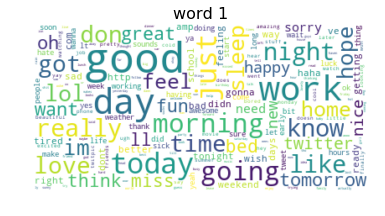

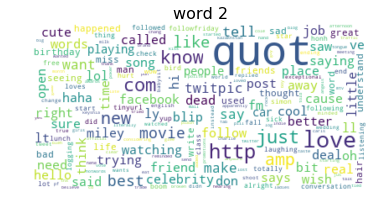

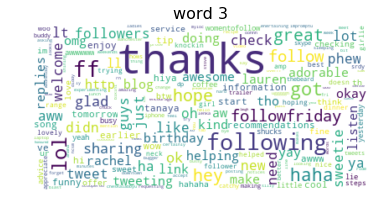

In [23]:
from wordcloud import WordCloud 
import matplotlib.pyplot as plt

%matplotlib inline

def draw_wordcloud(dict, topic_number):
    wc = WordCloud(max_words=1000)    
    wordcloud = WordCloud().generate_from_frequencies(dict)
    
    plt.title('word %s' %str(topic_number), size = 16)
    wordcloud = WordCloud(background_color='white',max_font_size = 50).generate_from_frequencies(dict)
    
    plt.imshow(wordcloud, interpolation="bilinear")
    plt.axis("off")        
    plt.show()

draw_wordcloud(dict(mywords_topic1), topic_number=1)
draw_wordcloud(dict(mywords_topic2), topic_number=2)
draw_wordcloud(dict(mywords_topic3), topic_number=3)

In [19]:
# Prediction example
text_new = preprocessed[0:5]
tfidf_new = vectorizer.transform(text_new)
W_new = nmf.transform(tfidf_new)